In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, roc_curve, auc, roc_auc_score

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

In [96]:
# Reading the dataset
data_csv = "parkinsons.data"
df = pd.read_csv(data_csv)#, names=['ID','Clump','U_Cell_size','U_Cell_shape','Marginal_Adhesion','SE_epitelial_cell_size','Bare_nuclei','bland_chromatin','Normal_Nucleoli','Mitoses','Class'])
print('Dataset shape: ', df.shape)
print(df.dtypes)
df.head()

Dataset shape:  (195, 24)
name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [97]:
# Verifying null values and deleting name from dataset
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())
# Drop the lines with null values
df = df.dropna()
# Removing name column since it won't be considered to the training
df.pop('name')
print('Dataset shape: ', df.shape)

Empty DataFrame
Columns: []
Index: []
Dataset shape:  (195, 23)


In [98]:
# Dataset distribution values
for name, values in df.iteritems():
    print (name, '\nMin Value:  ', np.min(values), '\nMax Value: ', np.max(values), '\n\n')

MDVP:Fo(Hz) 
Min Value:   88.333 
Max Value:  260.105 


MDVP:Fhi(Hz) 
Min Value:   102.145 
Max Value:  592.03 


MDVP:Flo(Hz) 
Min Value:   65.476 
Max Value:  239.17 


MDVP:Jitter(%) 
Min Value:   0.00168 
Max Value:  0.03316 


MDVP:Jitter(Abs) 
Min Value:   7e-06 
Max Value:  0.00026 


MDVP:RAP 
Min Value:   0.00068 
Max Value:  0.02144 


MDVP:PPQ 
Min Value:   0.00092 
Max Value:  0.01958 


Jitter:DDP 
Min Value:   0.00204 
Max Value:  0.06433 


MDVP:Shimmer 
Min Value:   0.00954 
Max Value:  0.11908 


MDVP:Shimmer(dB) 
Min Value:   0.085 
Max Value:  1.302 


Shimmer:APQ3 
Min Value:   0.00455 
Max Value:  0.05647 


Shimmer:APQ5 
Min Value:   0.0057 
Max Value:  0.0794 


MDVP:APQ 
Min Value:   0.00719 
Max Value:  0.13778 


Shimmer:DDA 
Min Value:   0.01364 
Max Value:  0.16942 


NHR 
Min Value:   0.00065 
Max Value:  0.31482 


HNR 
Min Value:   8.441 
Max Value:  33.047 


status 
Min Value:   0 
Max Value:  1 


RPDE 
Min Value:   0.25657 
Max Value:  0.685151 


DF

In [99]:
print(f"Total     = {len(df)} -> 100%")
print(f"Healthy    = {len(df[df.status == 0])} -> {len(df[df.status == 0])/len(df) *100}%")
print(f"Parkinson = {len(df[df.status == 1])} -> {len(df[df.status == 1])/len(df) *100}%")

Total     = 195 -> 100%
Healthy    = 48 -> 24.615384615384617%
Parkinson = 147 -> 75.38461538461539%


In [100]:
# Separate entries from outputs
dataset = df.to_numpy() # Converting from Pandas dataframe to Numpy
entries = df.loc[:, df.columns != 'status'].to_numpy(dtype=np.float64)
outputs = df['status'].to_numpy(dtype=np.int64)
print(entries.shape)
print(outputs.shape)

(195, 22)
(195,)


In [101]:
# Split dataset between train and test
seed = 10 # Set seed to get invariant results
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(entries, outputs, test_size=test_size, random_state=seed)
print('Train dataset shape:\nEntries: ', x_train.shape, '\nOutput: ', y_train.shape, '\n\n')
print('Test dataset shape:\nEntries: ', x_test.shape, '\nOutput: ', y_test.shape)

Train dataset shape:
Entries:  (156, 22) 
Output:  (156,) 


Test dataset shape:
Entries:  (39, 22) 
Output:  (39,)


In [102]:
# Create 10-fold validation set for training
K = 10
kf = StratifiedShuffleSplit(n_splits=K, random_state=seed)

In [103]:
# Decision Tree classifier
dt = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", min_samples_leaf=2, min_samples_split=5, max_depth=100)

In [104]:
# Random forest classifier
rf = RandomForestClassifier(n_estimators=10, random_state=seed, min_samples_split=5)

In [105]:
# Building the NN
class Neural_binary_classifier:
    def __init__(self, input_dim ,normalize_factor=0):
        self.normalize_factor = normalize_factor if normalize_factor > 0 else 1
        lr = 0.001          # learning rate
        lr_decay = 0.0005   # learning rate decay
        n_mini_batch = 100  # mini-batch length
        activation_fcn = "relu"
        optimizer = Adam(lr=lr, decay=lr_decay)
        h_n = 100
        self.model = Sequential()
        self.model.add(Dense(h_n, input_dim=input_dim, activation=activation_fcn,
                    kernel_regularizer=tf.keras.regularizers.l1(0.0001)))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    
    def fit(self,x_train,y_train):
        self.model.fit(x_train/self.normalize_factor, y_train,
                        epochs=200,
                        batch_size=50,
                        verbose=0,
                        callbacks=[
                            EarlyStopping(
                                monitor="loss", mode="min", min_delta=0.001, patience=30, verbose=1
                            )
                        ],
                      )

    def predict(self, x_test):
        y_valid_pred = self.model.predict(x_test/self.normalize_factor)
        to_bin = np.vectorize(lambda x : 1 if x > 0.5 else 0)
        
        return to_bin(y_valid_pred.flatten())

ann = Neural_binary_classifier(entries.shape[1], 10)

In [106]:
# Naive Bayes classifier
gnb = GaussianNB()

In [107]:
# SVM classifier
svm = svm.SVC()

In [108]:
classifiers = [(dt, "Decision tree"), (gnb, "Naive Bayes"), (ann, "Neural network"), (rf, "Random forest"), (svm, "SVM"), ]

In [109]:
# Training classifiers using cross-validation
fold_number = 1
for train_indexes, valid_indexes in kf.split(x_train, y_train):
    print("Fold ", fold_number)
    for classifier, label in classifiers:
        classifier.fit(x_train[train_indexes], y_train[train_indexes])
        y_valid_pred = classifier.predict(x_train[valid_indexes])
        print("Classifier type: ",label, ", Validation Accuracy = ", accuracy_score(y_train[valid_indexes], y_valid_pred))
    print('\n')
    fold_number += 1

Fold  1
Classifier type:  Decision tree , Validation Accuracy =  0.5625
Classifier type:  Naive Bayes , Validation Accuracy =  0.75
Classifier type:  Neural network , Validation Accuracy =  0.75
Classifier type:  Random forest , Validation Accuracy =  0.6875
Classifier type:  SVM , Validation Accuracy =  0.75


Fold  2
Classifier type:  Decision tree , Validation Accuracy =  0.6875
Classifier type:  Naive Bayes , Validation Accuracy =  0.75
Classifier type:  Neural network , Validation Accuracy =  0.6875
Classifier type:  Random forest , Validation Accuracy =  0.75
Classifier type:  SVM , Validation Accuracy =  0.75


Fold  3
Classifier type:  Decision tree , Validation Accuracy =  0.8125
Classifier type:  Naive Bayes , Validation Accuracy =  0.8125
Classifier type:  Neural network , Validation Accuracy =  0.8125
Classifier type:  Random forest , Validation Accuracy =  0.9375
Classifier type:  SVM , Validation Accuracy =  0.8125


Fold  4
Classifier type:  Decision tree , Validation Ac

In [110]:
# Testing classifiers
for classifier, label in classifiers:
    y_test_estimative = classifier.predict(x_test)
    print("Classifier type: ", label, ", Test Accuracy = ", accuracy_score(y_test, y_test_estimative))

Classifier type:  Decision tree , Test Accuracy =  0.9230769230769231
Classifier type:  Naive Bayes , Test Accuracy =  0.7692307692307693
Classifier type:  Neural network , Test Accuracy =  0.9487179487179487
Classifier type:  Random forest , Test Accuracy =  0.9487179487179487
Classifier type:  SVM , Test Accuracy =  0.8461538461538461


In [111]:
confusion_matrixes = np.zeros((len(classifiers), 4))
for index, classifier_info in enumerate(classifiers):
    confusion_matrixes[index,:] = np.array([confusion_matrix(y_test, classifier_info[0].predict(x_test)).ravel()])

<Figure size 432x288 with 0 Axes>

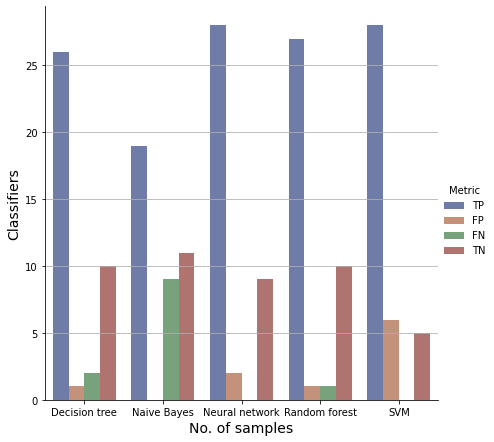

In [112]:
def plot_metrics(dataframe, metric_indexes, indexes_results, orientation, xlabel, ylabel):
    classifier_labels = ["Decision tree", "Naive Bayes", "Neural network", "Random forest", "SVM"]
    df_perf_results = pd.DataFrame(dataframe, columns=metric_indexes)
    df_perf_results.insert(0, 'classifier_type', classifier_labels, True)
    df_perf_results = pd.melt(df_perf_results, id_vars=['classifier_type'], value_vars=indexes_results, var_name='Metric')
    
    # Plot confusion matrixes for each classifier
    plt.figure()
    if orientation=="h":
        x = "value"
        y = "classifier_type"
        gridon = "x"
    else:
        y = "value"
        x = "classifier_type"
        gridon = "y"

    x = "value" if orientation=="h" else "classifier_type"
    y = "classifier_type" if orientation=="h" else "value"
    sns.catplot(data=df_perf_results, kind="bar", orient=orientation, x=x, y=y, hue="Metric", ci="sd", palette="dark", alpha=.6, height=6)
    plt.ylabel(xlabel, fontsize=14)
    plt.xlabel(ylabel, fontsize=14)
    if indexes_results == ["AUC", "CA", "Pre", "Rec"]:
        plt.ylim([0.88, 1])
    plt.grid(axis=gridon)
    plt.show()

# Generate dataset to plot using seaborn package
indexes = ["TN", "FP", "FN", "TP"]
indexes_result1 = ["TP", "FP", "FN", "TN"]

plot_metrics(confusion_matrixes, indexes, indexes_result1, "v", "Classifiers", "No. of samples")

In [113]:
df_confusion_matrixes = pd.DataFrame(confusion_matrixes, columns=indexes, index=[label for _, label in classifiers])
df_confusion_matrixes.T

,Decision tree,Naive Bayes,Neural network,Random forest,SVM
TN,10.0,11.0,9.0,10.0,5.0
FP,1.0,0.0,2.0,1.0,6.0
FN,2.0,9.0,0.0,1.0,0.0
TP,26.0,19.0,28.0,27.0,28.0


In [114]:
def perf_metrics(confusion_values):
    # [0] = TN, [1] = FP, [2] = FN, [3] = TP
    # 4.1 accuracy
    accuracy = (confusion_values[3] + confusion_values[0]) / (np.sum(confusion_values))
    # 4.2 precision
    precision = confusion_values[3] / (confusion_values[3] + confusion_values[1])
    # 4.3 specificity
    specificity = confusion_values[0] / (confusion_values[0] + confusion_values[1])
    # 4.4 TP rate
    tp_rate = confusion_values[3] / (confusion_values[3] + confusion_values[2])
    # 4.5 FP rate
    fp_rate = confusion_values[1] / (confusion_values[1] + confusion_values[0])
    # 4.6 NPV
    npv = confusion_values[0] / (confusion_values[0] + confusion_values[2])
    # 4.7 Rate of Misclassification
    misclassification_rate = (confusion_values[1] + confusion_values[2]) / (np.sum(confusion_values))
    # 4.8 F1 Score
    f1_score = 2*(precision * tp_rate) / (precision + tp_rate)

    return np.array([accuracy, precision, specificity, tp_rate, fp_rate, npv, misclassification_rate, f1_score])

perf_results = np.zeros((confusion_matrixes.shape[0], 10))
for i in np.arange(confusion_matrixes.shape[0]):
    perf_results[i,0:8] = perf_metrics(confusion_matrixes[i,:])

# Calculate AUC and ROC curve and Mean Absolute Error (MEA)
fpr = dict()
tpr = dict()
roc_auc = dict()
mae = dict()

for index, classifier_info in enumerate(classifiers):
    fpr[classifier_info[1]], tpr[classifier_info[1]], _ = roc_curve(y_test, classifier_info[0].predict(x_test))
    roc_auc[classifier_info[1]] = auc(fpr[classifier_info[1]], tpr[classifier_info[1]])
    mae[classifier_info[1]] = mean_absolute_error(y_test, classifier_info[0].predict(x_test))
perf_results[:,8] = [roc_auc[i] for i in roc_auc]
perf_results[:,9] = [mae[i] for i in mae]


<Figure size 432x288 with 0 Axes>

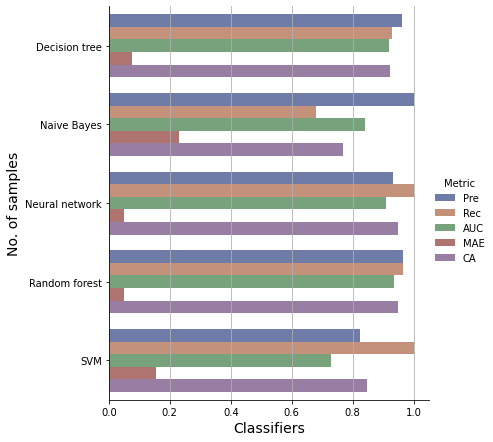

In [115]:
metric_indexes = ["CA", "Pre", "Spec", "Rec", "FPR", "NPV", "RMC", "F1", "AUC", "MAE"] # that stands for Classification accuracy, Precision, Specificity, Recall/TP rate, 
# False positive rate, negative predictive value, misclassification rate and F1, respectively.
indexes_result2 = ["Pre", "Rec", "AUC", "MAE", "CA"]

plot_metrics(perf_results, metric_indexes, indexes_result2, "h", "No. of samples", "Classifiers")

In [116]:
df_perf_results = pd.DataFrame(perf_results, columns=metric_indexes, index=[label for _, label in classifiers])
df_perf_results[indexes_result2]

,Pre,Rec,AUC,MAE,CA
Decision tree,0.962963,0.928571,0.918831,0.076923,0.923077
Naive Bayes,1.000000,0.678571,0.839286,0.230769,0.769231
Neural network,0.933333,1.000000,0.909091,0.051282,0.948718
Random forest,0.964286,0.964286,0.936688,0.051282,0.948718
SVM,0.823529,1.000000,0.727273,0.153846,0.846154


In [117]:
# Table 4 equivalent
result_labels = ["TP", "FP", "Pre", "Rec", "AUC", "MAE", "CA"]
df_results_original = pd.concat([df_confusion_matrixes.T, df_perf_results.T]).T
df_results_original[result_labels]

,TP,FP,Pre,Rec,AUC,MAE,CA
Decision tree,26.0,1.0,0.962963,0.928571,0.918831,0.076923,0.923077
Naive Bayes,19.0,0.0,1.000000,0.678571,0.839286,0.230769,0.769231
Neural network,28.0,2.0,0.933333,1.000000,0.909091,0.051282,0.948718
Random forest,27.0,1.0,0.964286,0.964286,0.936688,0.051282,0.948718
SVM,28.0,6.0,0.823529,1.000000,0.727273,0.153846,0.846154


# Here we start to evaluate results using a modified dataset processed by MFEA technique described in the paper

In [118]:
mod_df = pd.read_csv(data_csv)
mod_df.pop('name')
# Separate entries from outputs
mod_dataset = mod_df.to_numpy() # Converting from Pandas dataframe to Numpy
mod_entries = mod_df.loc[:, mod_df.columns != 'status'].to_numpy(dtype=np.float64)
mod_outputs = mod_df['status'].to_numpy(dtype=np.int64)
print(mod_entries.shape)
print(mod_outputs.shape)

(195, 22)
(195,)


# First Agent

In [119]:
fa_scores = np.abs(np.sum(np.corrcoef(mod_dataset.T), axis=1))
fa_order = fa_scores.argsort()+1
fa_order

array([ 1,  2,  3, 19, 17, 18, 21, 22, 20, 23, 15, 16,  5, 11, 14,  8,  6,
       12,  4, 13,  9,  7, 10])

# Second agent

In [120]:
sa = SelectKBest(score_func=f_classif, k="all")
sa_fit = sa.fit(mod_entries, mod_outputs)
sa_scores = sa_fit.scores_
sa_order = sa_scores.argsort()+1
sa_order

array([ 2, 15, 18,  8,  6,  4,  7, 17,  5, 21, 14, 11, 10, 12, 16, 13,  9,
        3,  1, 20, 22, 19])

# Third Agent

In [121]:
ta_info_gain = mutual_info_classif(mod_entries, mod_outputs)
ta_entropy = [entropy(feature) for feature in mod_entries.T]
ta_scores = ta_info_gain/ta_entropy
ta_order = ta_scores.argsort()+1
ta_order

array([21, 17, 18,  9,  8,  6,  7, 11, 14, 10, 12,  4, 15, 16,  2,  3, 13,
       20,  1, 19,  5, 22])

# Fourth Agent

In [122]:
fa_scores = mutual_info_classif(mod_entries, mod_outputs)
fa_order = ta_scores.argsort()+1
fa_order

array([21, 17, 18,  9,  8,  6,  7, 11, 14, 10, 12,  4, 15, 16,  2,  3, 13,
       20,  1, 19,  5, 22])

# Fifth Agent

In [123]:
# example
ffa_scores = np.arange(0, 22)
ffa_order = ffa_scores.argsort()+1
ffa_order

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22])

# Selecting features based on agent scores/order

In [124]:
orders = np.array([[fa_order], [sa_order], [ta_order], [fa_order], [ffa_order]])
orders

array([[[21, 17, 18,  9,  8,  6,  7, 11, 14, 10, 12,  4, 15, 16,  2,  3,
         13, 20,  1, 19,  5, 22]],

       [[ 2, 15, 18,  8,  6,  4,  7, 17,  5, 21, 14, 11, 10, 12, 16, 13,
          9,  3,  1, 20, 22, 19]],

       [[21, 17, 18,  9,  8,  6,  7, 11, 14, 10, 12,  4, 15, 16,  2,  3,
         13, 20,  1, 19,  5, 22]],

       [[21, 17, 18,  9,  8,  6,  7, 11, 14, 10, 12,  4, 15, 16,  2,  3,
         13, 20,  1, 19,  5, 22]],

       [[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22]]])

In [125]:
# First filter, selecting 14 features by frequency
frequency = np.squeeze(np.sum(orders<15, axis=0))
print("Frequency: ", frequency)
order = np.argsort(np.argsort(-frequency))+1
print("Order: ", order)
frequency_order = np.where(order>14, 0, order)
print("First 14 selected features: ", frequency_order) # Only first 14th features were selected in this first step

Frequency:  [2 1 1 5 5 5 5 4 5 4 5 5 2 2 3 4 4 1 4 0 3 0]
Order:  [15 20 18  2  3  4  5 10  6 11  1  7 16 17 14 12  9 19  8 21 13 22]
First 14 selected features:  [ 0  0  0  2  3  4  5 10  6 11  1  7  0  0 14 12  9  0  8  0 13  0]


In [126]:
# Second filter to select 11 features from 14
first_filter_mask = frequency_order!=0
orders_sum = np.squeeze(np.sum(orders, axis=0))
rank = np.nan_to_num((orders_sum/frequency) * first_filter_mask)
rank = np.argsort(np.argsort(np.where(rank==0, 99, rank))) +1
features_mask = rank<12
selected_features_labels = mod_df.columns[mod_df.columns != "status"][features_mask]
print("Selected features: ", selected_features_labels)

Selected features:  Index(['MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ',
       'Jitter:DDP', 'MDVP:Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'NHR',
       'HNR', 'spread1'],
      dtype='object')
/home/cleversonahum/.local/share/virtualenvs/breast_cancer_diagnosis-cqtohL5j/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/cleversonahum/.local/share/virtualenvs/breast_cancer_diagnosis-cqtohL5j/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


In [127]:
# Creating new entries based on feature selection, now only 11 features are used
selected_entries = mod_entries[:, features_mask]
print("New entries shape: ", selected_entries.shape)

New entries shape:  (195, 11)
